herein is my code that explores creating a neural network in order to tackle the binary classifcation problem of prediciting credit card defaults next month utilising the CCD dataset.
I first plot and clean the data and examine the class imbalance, after which I create an initial model and then investigate other hyperparamters and document these within my report before attempting a more complete model using these tuned hyperparamters

# Importing

In [1]:
!pip install scikit-learn

In [30]:
#packages to handle numerics, dataframes and plotting
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# importing ml libraries which will aid in preprocessing data
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split



# packages for constructing neural network
# basic model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# over/ under sampling and smote
from collections import Counter
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Progress bar for large hyperparameter tuning
from tqdm import tqdm

# evaluation metric for later models
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score


In [4]:
#import df, setting the header to be the first row.
df = pd.read_csv('/content/CCD.csv',header = 1)


In [5]:
#shorten name of target column for ease
df=df.rename(columns = {'default payment next month':'default'})
#rename pay0 as was inconsistant with naming scheme
df=df.rename(columns = {'PAY_0':'PAY_1'})

# Data checks

In [6]:
#check for missing values, data types- all columns contain 30,000 items same as index therfore no blanks, no not numbers
#df.isna().sum()
non_numeric_columns = df.select_dtypes(exclude='number').columns
non_numeric_columns
# this shows there are no non numeric data points

Index([], dtype='object')

In [7]:
# Checking the range of the numerical entries, on transposed df for ease of reading
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


# Visualisation

<ipython-input-8-8b6c0672d1db>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="default", data=df, palette='Blues')


Text(0.5, 1.0, 'Distribution of defaulters vs non-defaulters')

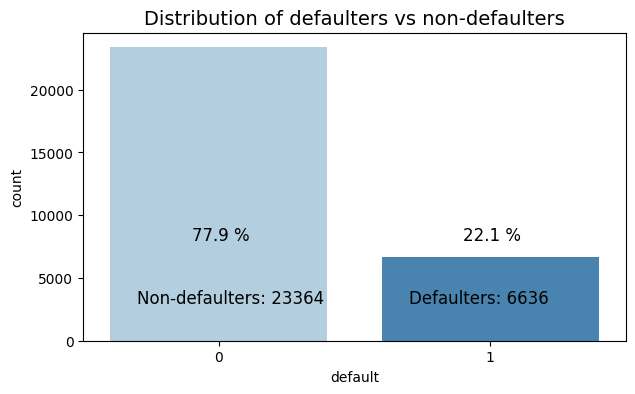

In [8]:
# The frequency of defaults
defs = df["default"].sum()
non_defs = len(df) - defs

# find Percentages
def_perc = round(defs / len(df) * 100, 1)
non_def_perc = round(non_defs / len(df) * 100, 1)

#establish figure
plt.figure(figsize=(7, 4))


# Plot countplot for 'default' column using seaborn
# Annotations show counts and percentages of defaulters and non-defaulters
sns.countplot(x="default", data=df, palette='Blues')

# Annotations for counts
plt.annotate("Non-defaulters: {}".format(non_defs), xy=(-0.3, 15000), xytext=(-0.3, 3000), size=12)
plt.annotate("Defaulters: {}".format(defs), xy=(0.7, 15000), xytext=(0.7, 3000), size=12)

# Annotations for percentages
plt.annotate(str(non_def_perc) + " %", xy=(-0.3, 15000), xytext=(-0.1, 8000), size=12)
plt.annotate(str(def_perc) + " %", xy=(0.7, 15000), xytext=(0.9, 8000), size=12)

# Set the title of the plot
plt.title("Distribution of defaulters vs non-defaulters", size=14)


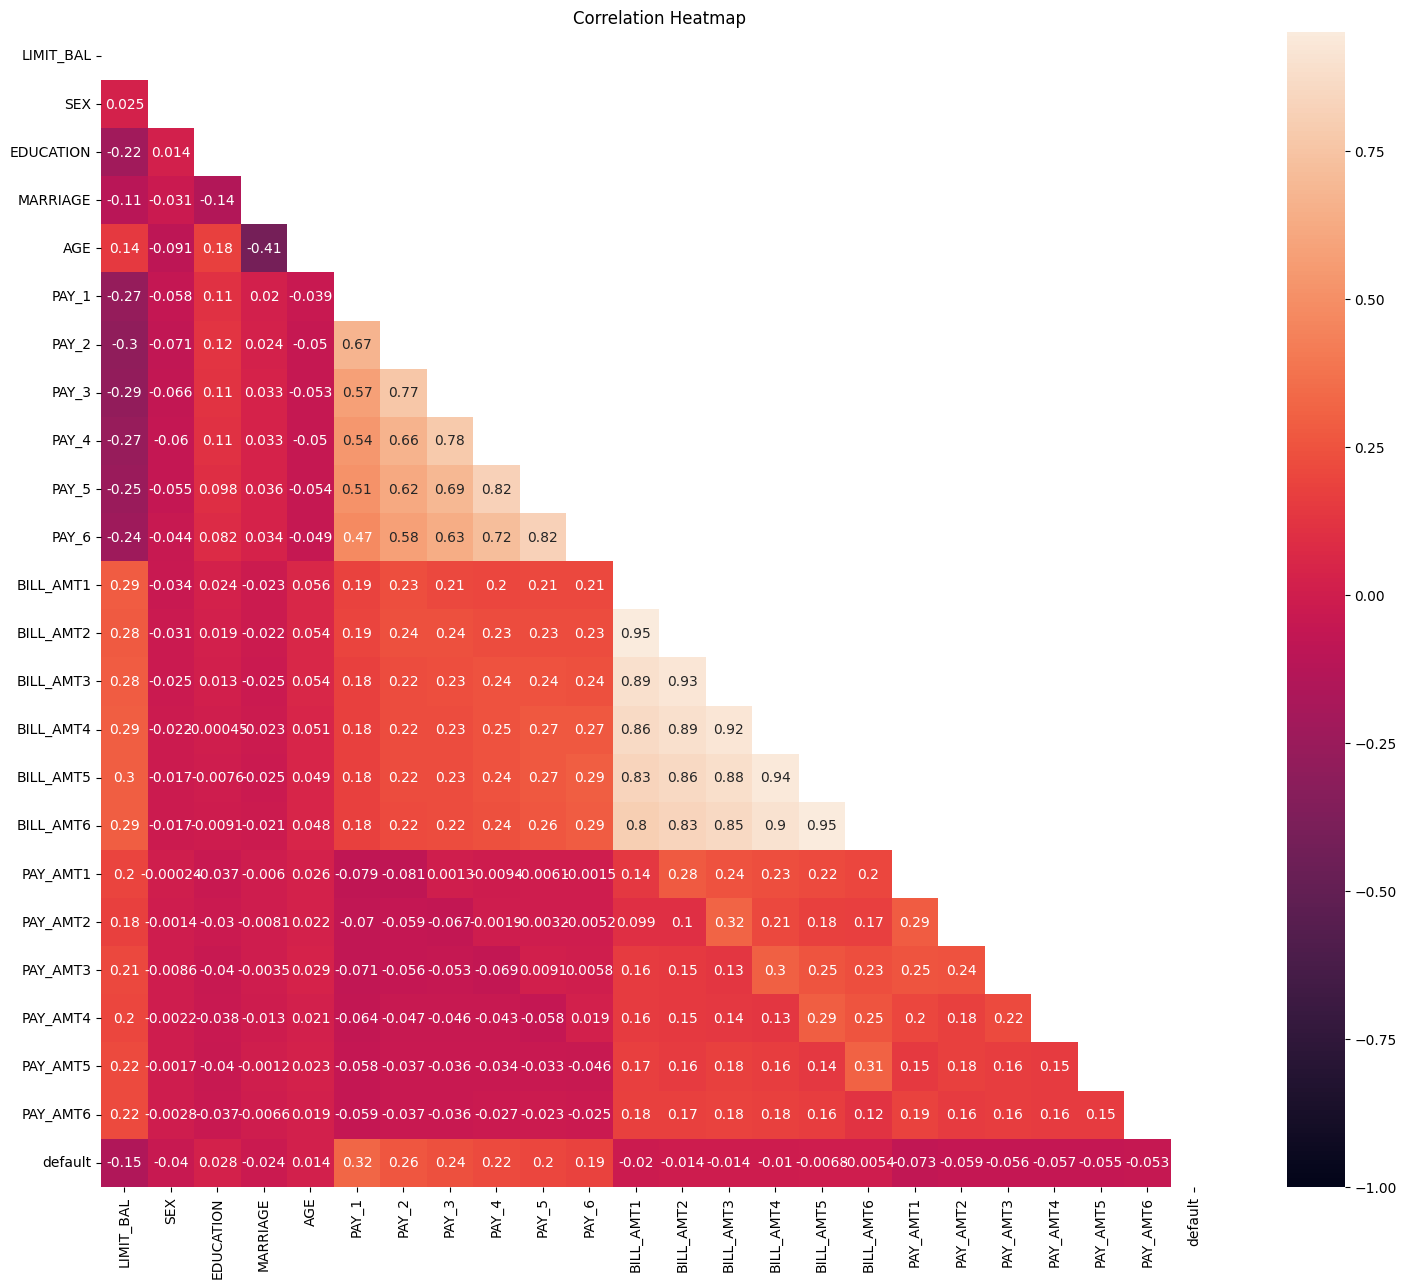

In [9]:
#create a correlation heatmap that whos how each factor relates to one another
corr = df.corr()

#create fig of size
plt.figure(figsize=(18, 15))
#top diagonal mask initialised
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, vmin=-1.0,mask=mask)

plt.title("Correlation Heatmap")
plt.show()


this heatmap shows that there is no direct features that will be responsible for the success of the model, therefore we need all features

# Preprocessing

In [10]:
# Creating a function which will ohe categorical columns, will be called in the preprocessing function
def onehot_encode(df, column_dict):
    #creates a copy of the df so a new df is created that has the processed data
    df_processed = df.copy()
    #iterate through all columns in the passed column directory
    for column, prefix in column_dict.items():
        # Perform one-hot encoding for the current column with the specified prefix using the pandas dummy function
        dummies = pd.get_dummies(df_processed[column], prefix=prefix)
        # Concatenate the one-hot encoded columns with the original DataFrame
        df_processed = pd.concat([df_processed, dummies], axis=1)
        # Drop the original unencoded column
        df_processed = df_processed.drop(column, axis=1)

    return df_processed


In [11]:
# a function which will be called repeatedly that performs all preprocessing methods, will return scaled X features and target column y (unchanged)
def preprocess_inputs(df):
    # Create a copy of the DataFrame to preserve the original data, new copy will be ohe'd
    df_processed = df.copy()
    # Perform one-hot encoding for selected categorical columns, education and marriage as they are not ordinal
    df_processed = onehot_encode(
        df_processed,
        {
            'EDUCATION': 'EDU',
            'MARRIAGE': 'MAR'
        }
    )
    df_processed['SEX'] = df_processed['SEX'].replace(2, 0)
    # Drop the 'SEX' column from the DataFrame, i Don't want to encode this I want it as a switch
    sex_column = df_processed['SEX'].copy()
    df_processed.drop('SEX', axis=1, inplace=True)

    # Split df_processed into X (all features) and y (the output of default)
    y = df_processed['default'].copy()
    X = df_processed.drop('default', axis=1).copy()

    # Scale the features (X) using StandardScaler
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Include the 'SEX' column back into the scaled data
    X_scaled['SEX'] = sex_column

    return X_scaled, y


In [12]:
#setting the target df y and features df X after all have been preprocessed
X, y = preprocess_inputs(df)

In [13]:
#inspect X
X

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDU_2,EDU_3,EDU_4,EDU_5,EDU_6,MAR_0,MAR_1,MAR_2,MAR_3,SEX
0,-1.136720,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,-1.486041,-0.642501,-0.647399,...,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,0
1,-0.365981,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,1.992316,-0.659219,-0.666747,...,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,0
2,-0.597202,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.298560,-0.493899,...,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,0
3,-0.905498,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.057491,-0.013293,...,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,0
4,-0.905498,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,0.253137,-0.578618,-0.611318,...,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.404759,0.381275,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,1.870379,2.018136,...,-0.937295,2.258602,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,1
29996,-0.134759,0.815221,-0.874991,-0.723570,-0.696663,-0.666599,0.234917,0.253137,-0.672786,-0.665299,...,-0.937295,2.258602,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,1
29997,-1.059646,0.164303,3.574267,2.617654,1.809921,-0.666599,0.234917,0.253137,-0.647227,-0.643830,...,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,1
29998,-0.674276,0.598248,0.904712,-0.723570,0.138865,0.188746,0.234917,-0.616452,-0.717982,0.410269,...,-0.937295,2.258602,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,1


In [14]:
#inspect standard deviations and spread of data to ensure all was succesful
X.describe()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDU_2,EDU_3,EDU_4,EDU_5,EDU_6,MAR_0,MAR_1,MAR_2,MAR_3,SEX
count,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,...,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,30000.000000
mean,-6.063298e-17,-1.856885e-16,-1.894781e-17,4.926430e-17,-5.494864e-17,3.126388e-17,-3.031649e-17,4.547474e-17,-1.231607e-17,-3.789561e-17,...,-4.642213e-17,4.168517e-17,-6.631732e-18,-4.926430e-17,1.492140e-17,-5.092223e-18,9.473903e-18,-1.515825e-17,-7.105427e-17,0.396267
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,...,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,0.489129
min,-1.213794e+00,-1.571479e+00,-1.764843e+00,-1.558876e+00,-1.532192e+00,-1.521944e+00,-1.530046e+00,-1.486041e+00,-2.944312e+00,-1.671375e+00,...,-9.372952e-01,-4.427518e-01,-6.416291e-02,-9.706320e-02,-4.126615e-02,-4.246464e-02,-9.142609e-01,-1.066471e+00,-1.043257e-01,0.000000
25%,-9.054983e-01,-8.120745e-01,-8.749911e-01,-7.235699e-01,-6.966635e-01,-6.665987e-01,-6.475648e-01,-6.164517e-01,-6.473120e-01,-6.490466e-01,...,-9.372952e-01,-4.427518e-01,-6.416291e-02,-9.706320e-02,-4.126615e-02,-4.246464e-02,-9.142609e-01,-1.066471e+00,-1.043257e-01,0.000000
50%,-2.118326e-01,-1.611565e-01,1.486052e-02,1.117361e-01,1.388648e-01,1.887461e-01,2.349165e-01,2.531374e-01,-3.916884e-01,-3.931159e-01,...,-9.372952e-01,-4.427518e-01,-6.416291e-02,-9.706320e-02,-4.126615e-02,-4.246464e-02,-9.142609e-01,9.376717e-01,-1.043257e-01,0.000000
75%,5.589071e-01,5.982479e-01,1.486052e-02,1.117361e-01,1.388648e-01,1.887461e-01,2.349165e-01,2.531374e-01,2.154919e-01,2.083271e-01,...,1.066900e+00,-4.427518e-01,-6.416291e-02,-9.706320e-02,-4.126615e-02,-4.246464e-02,1.093780e+00,9.376717e-01,-1.043257e-01,1.000000
max,6.416528e+00,4.720729e+00,7.133674e+00,6.794184e+00,6.823091e+00,7.031505e+00,7.294767e+00,7.209850e+00,1.240296e+01,1.313360e+01,...,1.066900e+00,2.258602e+00,1.558533e+01,1.030257e+01,2.423294e+01,2.354900e+01,1.093780e+00,9.376717e-01,9.585367e+00,1.000000


splits and shuffles x and y into train and test data set, using a seed so that the results are replicated each time.

In [15]:
#this function splits X into train, validation and test data sets. I use random states in order to reproduce data, it also shuffles the data.
def train_test_val_split(X, y):
    #split into test sets (0.2) of full data
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
    # Split train/validate sets (0.25) of full set
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=15)
    # Convert to numpy arrays to help with generate indeces below
    X, y = np.array(X), np.array(y)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [16]:
#call the function on data
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X, y)

In [17]:
#inspect training set
X_train

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDU_2,EDU_3,EDU_4,EDU_5,EDU_6,MAR_0,MAR_1,MAR_2,MAR_3,SEX
16868,1.406721,0.815221,-1.764843,-1.558876,-1.532192,-1.521944,-1.530046,-1.486041,-0.612963,-0.643142,...,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,1
8412,-1.059646,-1.571479,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.332267,-0.313998,...,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,0
28468,2.562830,-0.161156,-1.764843,-1.558876,-1.532192,-1.521944,-1.530046,-1.486041,-0.462436,-0.203801,...,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,0
13153,-0.134759,0.381275,1.794564,1.782348,0.138865,0.188746,0.234917,0.253137,1.432609,1.455124,...,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,0
21427,-0.443054,-1.246020,1.794564,0.111736,0.138865,0.188746,0.234917,1.992316,0.460377,-0.116577,...,-0.937295,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24626,-0.828424,0.489762,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,0.093701,0.062172,...,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,1
16522,-1.136720,-1.354506,0.904712,1.782348,0.138865,0.188746,0.234917,0.253137,-0.453297,-0.448460,...,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,1
10131,2.562830,-0.269643,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,1.130985,0.920339,...,1.066900,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,-0.914261,0.937672,-0.104326,1
15044,1.715017,-0.052670,0.014861,0.111736,0.138865,0.188746,0.234917,0.253137,-0.365675,-0.286277,...,-0.937295,-0.442752,-0.064163,-0.097063,-0.041266,-0.042465,1.093780,-1.066471,-0.104326,1


# Building Initial model

In [18]:
#here is my initial model which takes the suffcient input and has minimal tuning,
#it has been converted into a function to be called in rudamentry testing
def basic_model(X_train, y_train, X_val, y_val, X_test,y_test,epochs):
  # Define the model
  model = Sequential()

  # Add the input layer with 32 neurons
  model.add(Dense(32, input_dim=32, activation='relu'))

  # Add hidden layers
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))

  # Output layer with one neuron for binary classification
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])




  # fit/train the model
  history = model.fit(X_train, y_train,
                              epochs=epochs,
                              batch_size=64,
                              validation_data=(X_val, y_val))


  # Evaluate the model on the test data
  loss, accuracy = model.evaluate(X_test, y_test)
  print(f'Test Accuracy: {accuracy}')
  #return the history of the precision, so that they can eb plotted
  return history

history= basic_model(X_train, y_train, X_val, y_val, X_test,y_test,10)

Epoch 1/10
282/282 [==============================] - 2s 6ms/step - loss: 0.4744 - accuracy: 0.7983 - val_loss: 0.4347 - val_accuracy: 0.8240
Epoch 2/10
282/282 [==============================] - 1s 3ms/step - loss: 0.4452 - accuracy: 0.8135 - val_loss: 0.4248 - val_accuracy: 0.8265
Epoch 3/10
282/282 [==============================] - 1s 3ms/step - loss: 0.4400 - accuracy: 0.8167 - val_loss: 0.4222 - val_accuracy: 0.8262
Epoch 4/10
282/282 [==============================] - 1s 3ms/step - loss: 0.4361 - accuracy: 0.8183 - val_loss: 0.4217 - val_accuracy: 0.8263
Epoch 5/10
282/282 [==============================] - 1s 3ms/step - loss: 0.4342 - accuracy: 0.8191 - val_loss: 0.4218 - val_accuracy: 0.8287
Epoch 6/10
282/282 [==============================] - 1s 3ms/step - loss: 0.4323 - accuracy: 0.8194 - val_loss: 0.4207 - val_accuracy: 0.8285
Epoch 7/10
282/282 [==============================] - 1s 3ms/step - loss: 0.4304 - accuracy: 0.8202 - val_loss: 0.4191 - val_accuracy: 0.8287
Epoch 

## Plot loss curve

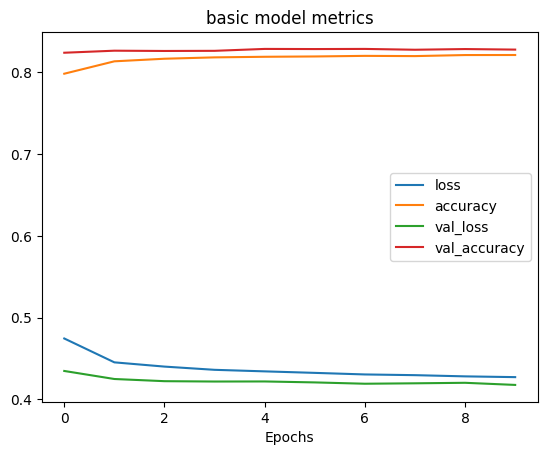

In [19]:
#function that I will call repeatedly that shows all basic metrics and how they change over the epochs
def basic_plot(history,title):
  pd.DataFrame(history.history).plot()
  plt.title(title)
  #plt.rcparams['titlesize'==10]
  plt.xlabel('Epochs')
  #plt.ylabel('Accuracy')

title = 'basic model metrics'
basic_plot(history,title)

# Learning rate

In [20]:
# Define the model2
model2 = Sequential()

# Add the input layer with 32 neurons
model2.add(Dense(32, input_dim=32, activation='relu'))

# Add hidden layers
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))

# Output layer with one neuron for binary classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model2
model2.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Learning rate scheduler to dynamically adjust the learning rate during training.
# exponentially increases the learning rate with each epoch,
# starting from 1e-4 and multiplying by 10^(epoch/20) / 20 epochs.
schedular = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

# Train the model2 including the callbacks, changing learning rate
history_lr = model2.fit(X_train, y_train,
                            epochs=10,
                            #batch_size=64,
                            callbacks=[schedular],
                            validation_data=(X_val, y_val))

# Evaluate the model2 on test data
loss, accuracy = model2.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


Epoch 1/10
563/563 [==============================] - 5s 5ms/step - loss: 0.5356 - accuracy: 0.7702 - val_loss: 0.4918 - val_accuracy: 0.7958 - lr: 1.0000e-04
Epoch 2/10
563/563 [==============================] - 2s 4ms/step - loss: 0.4884 - accuracy: 0.7953 - val_loss: 0.4650 - val_accuracy: 0.8115 - lr: 1.1220e-04
Epoch 3/10
563/563 [==============================] - 2s 4ms/step - loss: 0.4698 - accuracy: 0.7999 - val_loss: 0.4511 - val_accuracy: 0.8148 - lr: 1.2589e-04
Epoch 4/10
563/563 [==============================] - 2s 3ms/step - loss: 0.4600 - accuracy: 0.8046 - val_loss: 0.4429 - val_accuracy: 0.8173 - lr: 1.4125e-04
Epoch 5/10
563/563 [==============================] - 2s 3ms/step - loss: 0.4524 - accuracy: 0.8087 - val_loss: 0.4368 - val_accuracy: 0.8210 - lr: 1.5849e-04
Epoch 6/10
563/563 [==============================] - 2s 3ms/step - loss: 0.4466 - accuracy: 0.8112 - val_loss: 0.4324 - val_accuracy: 0.8250 - lr: 1.7783e-04
Epoch 7/10
563/563 [==========================

### plot learning rate against loss

Text(0.5, 1.0, 'Learning Rate against Loss Curve')

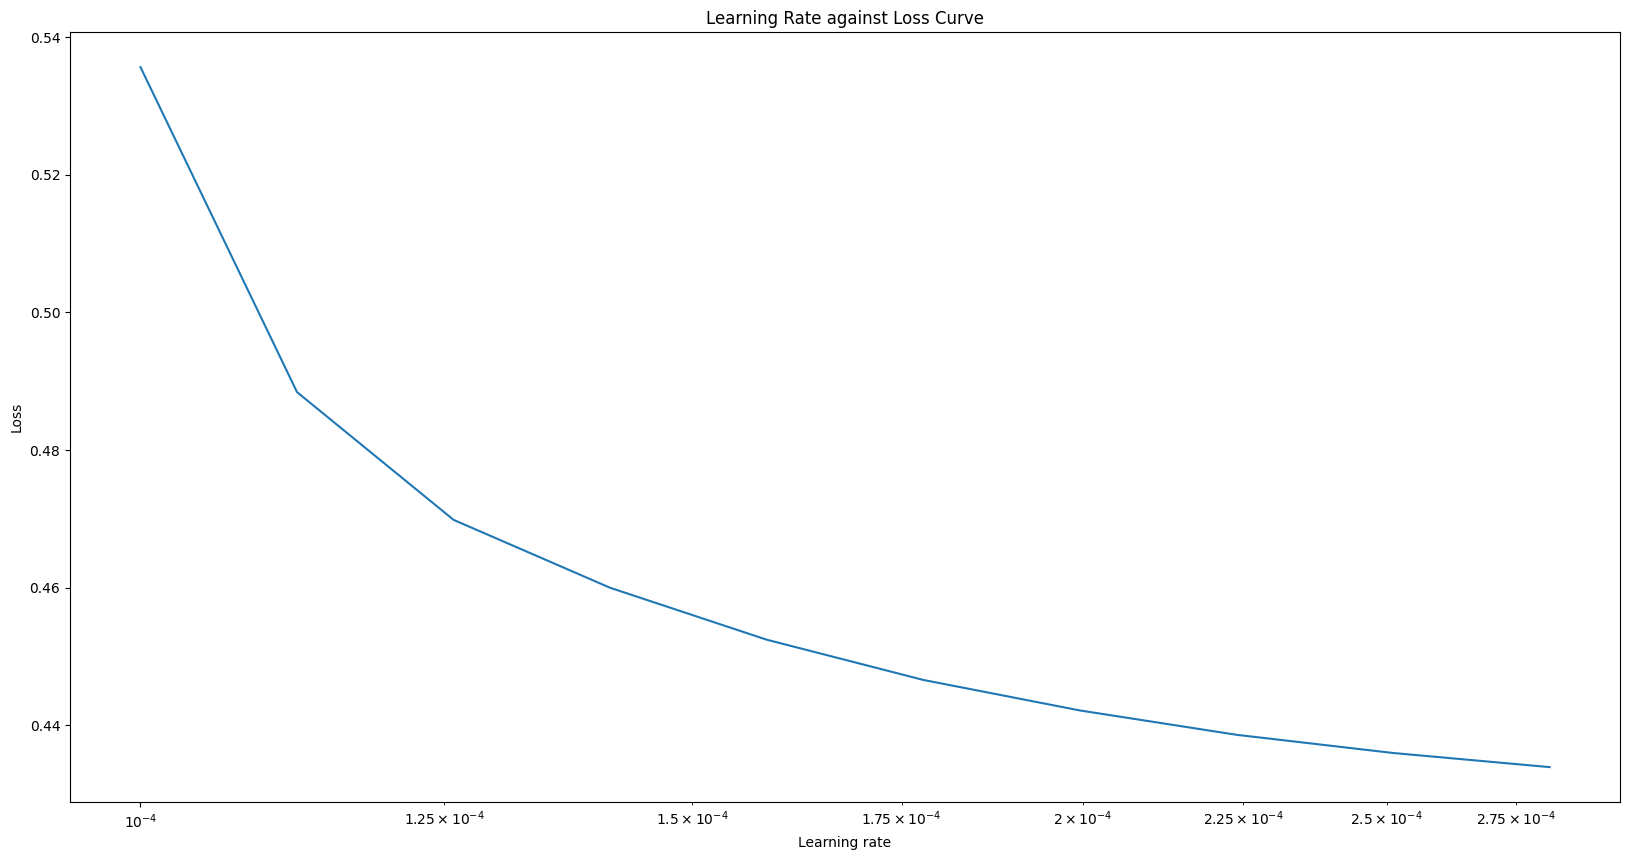

In [21]:
# Defining learning rates from 1e-4 to 1e-4*(10**(9/20)) in a logarithmic scale
lrs = 1e-4*(10**(tf.range(10)/20))

# Creating a figure with specified size
plt.figure(figsize=(20, 10))

# Plotting the learning rate against the loss
plt.semilogx(lrs, history_lr.history['loss'])

# Labeling x-axis as 'learning rate', y-axis as 'loss', and providing a title for the plot
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('Learning Rate against Loss Curve')



# Imbalanced data

I am investigating different sampling techniques, random over/under sampling and smote. I will then call these points through the train_test_val_split.

### Random Oversampling

In [22]:
# Setting the oversampling ratio
over_ratio = 0.75

# Initializing the RandomOverSampler with the specified sampling strategy and random state
rus = RandomOverSampler(sampling_strategy=over_ratio, random_state=621)

# Resampling the dataset to balance the classes
X_resampled_over, y_resampled_over = rus.fit_resample(X, y)

# Printing the count of each class after oversampling and the shape of the resampled dataset
print(sorted(Counter(y_resampled_over).items()), y_resampled_over.shape)


[(0, 23364), (1, 17523)] (40887,)


### Random Undersdampling

In [23]:
# Setting the undersampling ratio
under_ratio = 1

# Initializing the RandomUnderSampler with the specified sampling strategy and random state
ros = RandomUnderSampler(sampling_strategy=under_ratio, random_state=69)

# Resampling the dataset to balance the classes
X_resampled_under, y_resampled_under = ros.fit_resample(X, y)

# Printing the count of each class after undersampling and the shape of the resampled dataset
print(sorted(Counter(y_resampled_under).items()), y_resampled_under.shape)


[(0, 6636), (1, 6636)] (13272,)


## Fitting

### Under

Epoch 1/10
125/125 [==============================] - 1s 3ms/step - loss: 0.6373 - accuracy: 0.6359 - val_loss: 0.5988 - val_accuracy: 0.6889
Epoch 2/10
125/125 [==============================] - 0s 2ms/step - loss: 0.5965 - accuracy: 0.6886 - val_loss: 0.5760 - val_accuracy: 0.6976
Epoch 3/10
125/125 [==============================] - 0s 2ms/step - loss: 0.5842 - accuracy: 0.6939 - val_loss: 0.5705 - val_accuracy: 0.6949
Epoch 4/10
125/125 [==============================] - 0s 2ms/step - loss: 0.5777 - accuracy: 0.6962 - val_loss: 0.5688 - val_accuracy: 0.6964
Epoch 5/10
125/125 [==============================] - 0s 2ms/step - loss: 0.5727 - accuracy: 0.7017 - val_loss: 0.5677 - val_accuracy: 0.6998
Epoch 6/10
125/125 [==============================] - 0s 2ms/step - loss: 0.5701 - accuracy: 0.7041 - val_loss: 0.5687 - val_accuracy: 0.6976
Epoch 7/10
125/125 [==============================] - 0s 2ms/step - loss: 0.5683 - accuracy: 0.7045 - val_loss: 0.5645 - val_accuracy: 0.6991
Epoch 

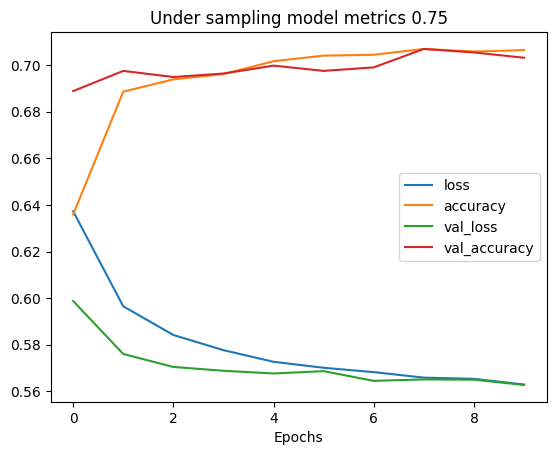

In [24]:
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X_resampled_under, y_resampled_under)
under_history = basic_model(X_train, y_train, X_val, y_val, X_test,y_test,10)
basic_plot(under_history,'Under sampling model metrics 0.75')

### Over

Epoch 1/10
384/384 [==============================] - 1s 2ms/step - loss: 0.5891 - accuracy: 0.7048 - val_loss: 0.5568 - val_accuracy: 0.7278
Epoch 2/10
384/384 [==============================] - 1s 2ms/step - loss: 0.5636 - accuracy: 0.7261 - val_loss: 0.5517 - val_accuracy: 0.7316
Epoch 3/10
384/384 [==============================] - 1s 2ms/step - loss: 0.5583 - accuracy: 0.7276 - val_loss: 0.5479 - val_accuracy: 0.7307
Epoch 4/10
384/384 [==============================] - 1s 2ms/step - loss: 0.5546 - accuracy: 0.7271 - val_loss: 0.5465 - val_accuracy: 0.7323
Epoch 5/10
384/384 [==============================] - 1s 2ms/step - loss: 0.5518 - accuracy: 0.7280 - val_loss: 0.5444 - val_accuracy: 0.7345
Epoch 6/10
384/384 [==============================] - 1s 2ms/step - loss: 0.5474 - accuracy: 0.7285 - val_loss: 0.5423 - val_accuracy: 0.7340
Epoch 7/10
384/384 [==============================] - 1s 2ms/step - loss: 0.5463 - accuracy: 0.7294 - val_loss: 0.5396 - val_accuracy: 0.7337
Epoch 

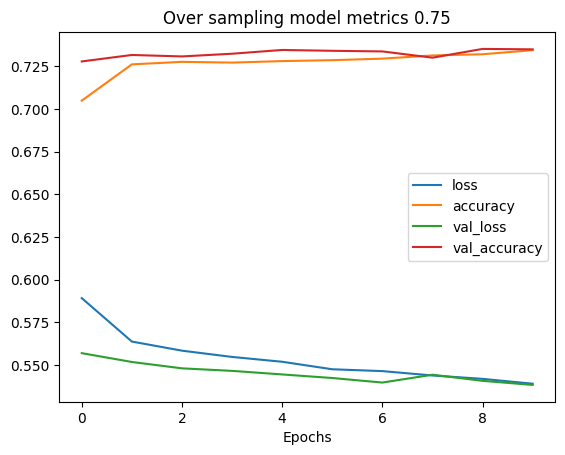

In [25]:

X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X_resampled_over, y_resampled_over)
over_history = basic_model(X_train, y_train, X_val, y_val, X_test,y_test,10)
basic_plot(over_history,'Over sampling model metrics 0.75')

### SMOTE

In [26]:
# Initialize SMOTE with a specified sampling strategy and random state.
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)
print(sorted(Counter(y_resampled_smote).items()), y_resampled_smote.shape)


[(0, 23364), (1, 23364)] (46728,)


Epoch 1/10
439/439 [==============================] - 2s 3ms/step - loss: 0.5924 - accuracy: 0.6806 - val_loss: 0.5751 - val_accuracy: 0.6972
Epoch 2/10
439/439 [==============================] - 1s 2ms/step - loss: 0.5663 - accuracy: 0.7015 - val_loss: 0.5681 - val_accuracy: 0.6986
Epoch 3/10
439/439 [==============================] - 1s 2ms/step - loss: 0.5606 - accuracy: 0.7064 - val_loss: 0.5673 - val_accuracy: 0.6937
Epoch 4/10
439/439 [==============================] - 1s 2ms/step - loss: 0.5554 - accuracy: 0.7096 - val_loss: 0.5617 - val_accuracy: 0.7050
Epoch 5/10
439/439 [==============================] - 1s 2ms/step - loss: 0.5533 - accuracy: 0.7111 - val_loss: 0.5578 - val_accuracy: 0.7064
Epoch 6/10
439/439 [==============================] - 1s 2ms/step - loss: 0.5504 - accuracy: 0.7137 - val_loss: 0.5581 - val_accuracy: 0.7055
Epoch 7/10
439/439 [==============================] - 1s 2ms/step - loss: 0.5470 - accuracy: 0.7160 - val_loss: 0.5547 - val_accuracy: 0.7086
Epoch 

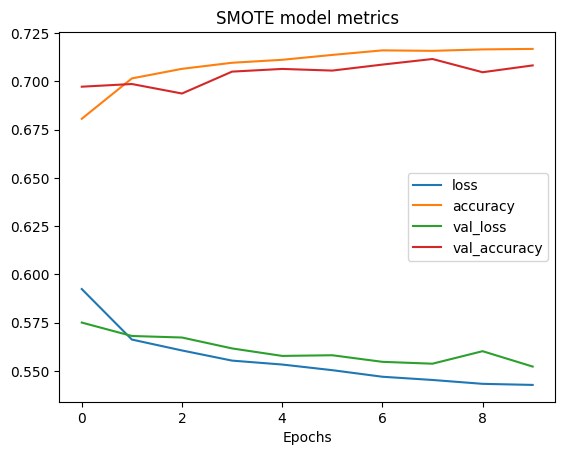

In [27]:
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X_resampled_smote, y_resampled_smote)
SMOTE_hist = basic_model(X_train, y_train, X_val, y_val, X_test,y_test,10)
basic_plot(SMOTE_hist,'SMOTE model metrics')

# loss function + weight

In [28]:
# define class weights
class_0_weight = 30000 / (2 * 23364)
class_1_weight = 30000 / (2 * 6636)

class_weights = {0: class_0_weight, 1:class_1_weight}

Epoch 1/100
563/563 [==============================] - 2s 3ms/step - loss: 0.6277 - accuracy: 0.6805 - val_loss: 0.6504 - val_accuracy: 0.6480
Epoch 2/100
563/563 [==============================] - 1s 2ms/step - loss: 0.5916 - accuracy: 0.7382 - val_loss: 0.5915 - val_accuracy: 0.7588
Epoch 3/100
563/563 [==============================] - 1s 2ms/step - loss: 0.5887 - accuracy: 0.7490 - val_loss: 0.5780 - val_accuracy: 0.7653
Epoch 4/100
563/563 [==============================] - 1s 2ms/step - loss: 0.5827 - accuracy: 0.7430 - val_loss: 0.5740 - val_accuracy: 0.7670
Epoch 5/100
563/563 [==============================] - 1s 2ms/step - loss: 0.5821 - accuracy: 0.7526 - val_loss: 0.5923 - val_accuracy: 0.7268
Epoch 6/100
563/563 [==============================] - 1s 2ms/step - loss: 0.5782 - accuracy: 0.7531 - val_loss: 0.5506 - val_accuracy: 0.7788
Epoch 7/100
563/563 [==============================] - 1s 2ms/step - loss: 0.5757 - accuracy: 0.7596 - val_loss: 0.5747 - val_accuracy: 0.7888

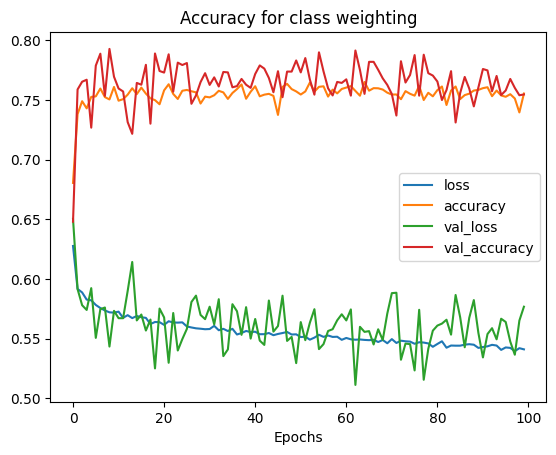

In [29]:

def systematic_tuning(X_train, y_train, X_val, y_val, X_test,y_test,epoch_n, dropout_rate, batch_r):
  '''This Function is a key tool for me to use in the examinnig of hyperparamters, it enables me to be able to change many of these features easily and compare easily, it includes epochs, depth, dropout, batch size,
  I can also manually change depth, activation functions and loss. T test data augmentation I can pass in different data'''
  # Define the model
  model = Sequential()

  # Add the input layer with 32 neurons
  model.add(Dense(32, input_dim=32, activation='relu'))
  model.add(Dropout(dropout_rate))
  # Add hidden layers
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(dropout_rate))
  # Output layer with one neuron for binary classification
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  # Train the model
  history = model.fit(X_train, y_train,
                              epochs=epoch_n,
                              batch_size=batch_r,
                              validation_data=(X_val, y_val),
                              class_weight = class_weights)

  # Evaluate the model on test data
  loss, accuracy = model.evaluate(X_test, y_test)
  print(f'Test Accuracy: {accuracy}')
  title = (f'Accuracy for class weighting')

  # Evaluate the model on test data
  y_pred_prob = model.predict(X_test)
  y_pred = (y_pred_prob > 0.5).astype(int)

  # Calculate precision, recall, F1-score, ROC-AUC, and PR-AUC
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred_prob)
  pr_auc = average_precision_score(y_test, y_pred_prob)

  # Extract loss and accuracy from the evaluation
  loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

  #print advanced metrics for comparison
  print(f'Test Accuracy: {accuracy}')
  print(f'Test Loss: {loss}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-score: {f1}')
  print(f'ROC-AUC: {roc_auc}')
  print(f'PR-AUC: {pr_auc}')
  return history, title

X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X, y)
detailed_history, detailed_title= systematic_tuning(X_train, y_train, X_val, y_val, X_test,y_test,100,0.25, 32 )


#X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X, y)
#detailed_history, detailed_title= systematic_tuning(X_train, y_train, X_val, y_val, X_test,y_test,10,0.1, 32 )
basic_plot(detailed_history,detailed_title)

# Systematic Hyperparameter Trials

In [35]:
##This Function is a key tool for me to use in the examining of hyperparameters, it enables me to be able to change many of these features easily and compare easily, it includes epochs, depth, dropout, batch size,
##I can also manually change depth, activation functions and loss. T test data augmentation I can pass in different data

#inputs: training data, number of epochs, dropout, batch size, datatyppe: data type is arbitrary, only used so that when accessing CSV it is clear where one dataset begins and ends.
# the function is called hundreds of time for each dataset as every combination of factors is trialed.
#history is returned

#the structure of the function is still similar to the basic model that has been shown.

def systematic_tuning(X_train, y_train, X_val, y_val, X_test, y_test, epoch_n, dropout_rate, batch_r, data_type):
    # Define the model
    model = Sequential()

    # Add the input layer with 32 neurons
    model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    # Add hidden layers- this is set up for the final test where I had a depth of
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    # Output layer with one neuron for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=epoch_n,
                        batch_size=batch_r,
                        validation_data=(X_val, y_val),
                        verbose=0)  # Set verbose to 0 to suppress training output

    # Evaluate the model on test data
    #return blank(irrelevant) and accuracy, a key metric
    blank, accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Evaluate the model on test data
    #calc predicted probability for test data
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate precision, recall, F1-score, ROC-AUC, and PR-AUC
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    pr_auc = average_precision_score(y_test, y_pred_prob)

    #Append parameters to DataFrame
    with open('hyperparameter_tuning.csv', 'a') as f:
        f.write(f"{epoch_n},{dropout_rate},{batch_r},6,{accuracy},{precision},{recall},{f1},{roc_auc},{pr_auc},{data_type}\n")

    return history

# Generate hyperparameters combinations, empty array that will store all
data = []
#reduced, (was 10,15,20)
epoch_values = [10]
dropout_rate_values = [0.1, 0.15, 0.2, 0.25]
batch_r_values = [16, 32, 64, 128, 256, 512]

#a list that contains all datatypes that will be passed into the systematic trial function (unedited, over/under sampled, SMOTE)
data_list = [(X, y), (X_resampled_smote, y_resampled_smote), (X_resampled_under, y_resampled_under),(X_resampled_smote,y_resampled_smote)]

# Iterate over data types
for data_type, (X_data, y_data) in enumerate(data_list):
    # Split data into training, validation, and test sets
    X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X_data, y_data)


    # Iterate over hyperparameters combinations
    total_iterations = len(epoch_values) * len(dropout_rate_values) * len(batch_r_values)
    #include pbar
    with tqdm(total=total_iterations, desc=f"Training models for {data_type}") as pbar:
        for epoch_n in epoch_values:
            for dropout_rate in dropout_rate_values:
                for batch_r in batch_r_values:
                    history = systematic_tuning(X_train, y_train, X_val, y_val, X_test, y_test, epoch_n, dropout_rate, batch_r, data_type)
                    #using progress bar as previous run with 20 epochs took ~ 3 hrs
                    pbar.update(1)



Training models for 0:   0%|          | 0/24 [00:00<?, ?it/s]

188/188 [==============================] - 0s 901us/step


Training models for 0:   4%|▍         | 1/24 [00:22<08:27, 22.05s/it]

188/188 [==============================] - 0s 938us/step


Training models for 0:   8%|▊         | 2/24 [00:33<05:48, 15.83s/it]

188/188 [==============================] - 0s 898us/step


Training models for 0:  12%|█▎        | 3/24 [00:39<04:02, 11.54s/it]

188/188 [==============================] - 0s 925us/step


Training models for 0:  17%|█▋        | 4/24 [00:44<02:56,  8.84s/it]

188/188 [==============================] - 0s 930us/step


Training models for 0:  21%|██        | 5/24 [00:48<02:10,  6.87s/it]

188/188 [==============================] - 0s 905us/step


Training models for 0:  25%|██▌       | 6/24 [00:50<01:39,  5.53s/it]

188/188 [==============================] - 0s 922us/step


Training models for 0:  29%|██▉       | 7/24 [01:09<02:47,  9.87s/it]

188/188 [==============================] - 0s 890us/step


Training models for 0:  33%|███▎      | 8/24 [01:21<02:45, 10.32s/it]

188/188 [==============================] - 0s 995us/step


Training models for 0:  38%|███▊      | 9/24 [01:27<02:18,  9.25s/it]

188/188 [==============================] - 0s 922us/step


Training models for 0:  42%|████▏     | 10/24 [01:32<01:48,  7.73s/it]

188/188 [==============================] - 0s 916us/step


Training models for 0:  46%|████▌     | 11/24 [01:36<01:26,  6.63s/it]

188/188 [==============================] - 0s 931us/step


Training models for 0:  50%|█████     | 12/24 [01:39<01:06,  5.57s/it]

188/188 [==============================] - 0s 930us/step


Training models for 0:  54%|█████▍    | 13/24 [01:58<01:47,  9.75s/it]

188/188 [==============================] - 0s 919us/step


Training models for 0:  58%|█████▊    | 14/24 [02:10<01:42, 10.23s/it]

188/188 [==============================] - 0s 943us/step


Training models for 0:  62%|██████▎   | 15/24 [02:17<01:22,  9.21s/it]

188/188 [==============================] - 0s 925us/step


Training models for 0:  67%|██████▋   | 16/24 [02:21<01:02,  7.80s/it]

188/188 [==============================] - 0s 962us/step


Training models for 0:  71%|███████   | 17/24 [02:25<00:46,  6.61s/it]

188/188 [==============================] - 0s 965us/step


Training models for 0:  75%|███████▌  | 18/24 [02:28<00:32,  5.47s/it]

188/188 [==============================] - 0s 924us/step


Training models for 0:  79%|███████▉  | 19/24 [02:52<00:54, 10.96s/it]

188/188 [==============================] - 0s 974us/step


Training models for 0:  83%|████████▎ | 20/24 [03:04<00:46, 11.50s/it]

188/188 [==============================] - 0s 937us/step


Training models for 0:  88%|████████▊ | 21/24 [03:16<00:34, 11.65s/it]

188/188 [==============================] - 0s 917us/step


Training models for 0:  92%|█████████▏| 22/24 [03:23<00:20, 10.24s/it]

188/188 [==============================] - 0s 955us/step


Training models for 0:  96%|█████████▌| 23/24 [03:28<00:08,  8.47s/it]

188/188 [==============================] - 0s 981us/step


Training models for 1:   0%|          | 0/24 [00:00<?, ?it/s]

293/293 [==============================] - 0s 943us/step


Training models for 1:   4%|▍         | 1/24 [00:42<16:23, 42.77s/it]

293/293 [==============================] - 0s 918us/step


Training models for 1:   8%|▊         | 2/24 [01:05<11:16, 30.77s/it]

293/293 [==============================] - 0s 899us/step


Training models for 1:  12%|█▎        | 3/24 [01:15<07:26, 21.26s/it]

293/293 [==============================] - 0s 906us/step


Training models for 1:  17%|█▋        | 4/24 [01:22<05:14, 15.70s/it]

293/293 [==============================] - 0s 898us/step


Training models for 1:  21%|██        | 5/24 [01:27<03:44, 11.83s/it]

293/293 [==============================] - 0s 912us/step


Training models for 1:  25%|██▌       | 6/24 [01:31<02:43,  9.10s/it]

293/293 [==============================] - 0s 846us/step


Training models for 1:  29%|██▉       | 7/24 [02:13<05:41, 20.07s/it]

293/293 [==============================] - 0s 881us/step


Training models for 1:  33%|███▎      | 8/24 [02:36<05:33, 20.86s/it]

293/293 [==============================] - 0s 882us/step


Training models for 1:  38%|███▊      | 9/24 [02:45<04:19, 17.30s/it]

293/293 [==============================] - 0s 1ms/step


Training models for 1:  42%|████▏     | 10/24 [02:52<03:15, 13.94s/it]

293/293 [==============================] - 0s 836us/step


Training models for 1:  46%|████▌     | 11/24 [02:56<02:23, 11.03s/it]

293/293 [==============================] - 0s 877us/step


Training models for 1:  50%|█████     | 12/24 [03:00<01:44,  8.74s/it]

293/293 [==============================] - 0s 901us/step


Training models for 1:  54%|█████▍    | 13/24 [03:43<03:30, 19.13s/it]

293/293 [==============================] - 0s 946us/step


Training models for 1:  58%|█████▊    | 14/24 [04:05<03:20, 20.07s/it]

293/293 [==============================] - 0s 887us/step


Training models for 1:  62%|██████▎   | 15/24 [04:17<02:38, 17.63s/it]

293/293 [==============================] - 0s 867us/step


Training models for 1:  67%|██████▋   | 16/24 [04:23<01:54, 14.29s/it]

293/293 [==============================] - 0s 859us/step


Training models for 1:  71%|███████   | 17/24 [04:28<01:19, 11.30s/it]

293/293 [==============================] - 0s 863us/step


Training models for 1:  75%|███████▌  | 18/24 [04:32<00:55,  9.21s/it]

293/293 [==============================] - 0s 845us/step


Training models for 1:  79%|███████▉  | 19/24 [05:00<01:14, 14.86s/it]

293/293 [==============================] - 0s 907us/step


Training models for 1:  83%|████████▎ | 20/24 [05:23<01:08, 17.17s/it]

293/293 [==============================] - 0s 867us/step


Training models for 1:  88%|████████▊ | 21/24 [05:32<00:44, 14.76s/it]

293/293 [==============================] - 0s 926us/step


Training models for 1:  92%|█████████▏| 22/24 [05:39<00:24, 12.41s/it]

293/293 [==============================] - 0s 851us/step


Training models for 1:  96%|█████████▌| 23/24 [05:43<00:09,  9.97s/it]

293/293 [==============================] - 0s 1ms/step


Training models for 2:   0%|          | 0/24 [00:00<?, ?it/s]

83/83 [==============================] - 0s 878us/step


Training models for 2:   4%|▍         | 1/24 [00:11<04:27, 11.61s/it]

83/83 [==============================] - 0s 943us/step


Training models for 2:   8%|▊         | 2/24 [00:18<03:09,  8.62s/it]

83/83 [==============================] - 0s 873us/step


Training models for 2:  12%|█▎        | 3/24 [00:22<02:17,  6.53s/it]

83/83 [==============================] - 0s 928us/step


Training models for 2:  17%|█▋        | 4/24 [00:24<01:40,  5.03s/it]

83/83 [==============================] - 0s 927us/step


Training models for 2:  21%|██        | 5/24 [00:27<01:19,  4.20s/it]

83/83 [==============================] - 0s 907us/step


Training models for 2:  25%|██▌       | 6/24 [00:29<01:02,  3.48s/it]

83/83 [==============================] - 0s 871us/step


Training models for 2:  29%|██▉       | 7/24 [00:38<01:30,  5.34s/it]

83/83 [==============================] - 0s 905us/step


Training models for 2:  33%|███▎      | 8/24 [00:45<01:29,  5.62s/it]

83/83 [==============================] - 0s 952us/step


Training models for 2:  38%|███▊      | 9/24 [00:51<01:27,  5.84s/it]

83/83 [==============================] - 0s 951us/step


Training models for 2:  42%|████▏     | 10/24 [00:55<01:13,  5.28s/it]

83/83 [==============================] - 0s 992us/step


Training models for 2:  46%|████▌     | 11/24 [00:58<00:58,  4.47s/it]

83/83 [==============================] - 0s 991us/step


Training models for 2:  50%|█████     | 12/24 [01:00<00:47,  3.92s/it]

83/83 [==============================] - 0s 1ms/step


Training models for 2:  54%|█████▍    | 13/24 [01:11<01:05,  5.93s/it]

83/83 [==============================] - 0s 955us/step


Training models for 2:  58%|█████▊    | 14/24 [01:17<01:01,  6.12s/it]

83/83 [==============================] - 0s 946us/step


Training models for 2:  62%|██████▎   | 15/24 [01:21<00:49,  5.47s/it]

83/83 [==============================] - 0s 929us/step


Training models for 2:  67%|██████▋   | 16/24 [01:25<00:40,  5.05s/it]

83/83 [==============================] - 0s 927us/step


Training models for 2:  71%|███████   | 17/24 [01:28<00:30,  4.35s/it]

83/83 [==============================] - 0s 953us/step


Training models for 2:  75%|███████▌  | 18/24 [01:31<00:23,  3.84s/it]

83/83 [==============================] - 0s 947us/step


Training models for 2:  79%|███████▉  | 19/24 [01:42<00:30,  6.19s/it]

83/83 [==============================] - 0s 1ms/step


Training models for 2:  83%|████████▎ | 20/24 [01:48<00:24,  6.06s/it]

83/83 [==============================] - 0s 883us/step


Training models for 2:  88%|████████▊ | 21/24 [01:52<00:16,  5.46s/it]

83/83 [==============================] - 0s 869us/step


Training models for 2:  92%|█████████▏| 22/24 [01:56<00:10,  5.00s/it]

83/83 [==============================] - 0s 914us/step


Training models for 2:  96%|█████████▌| 23/24 [01:59<00:04,  4.30s/it]

83/83 [==============================] - 0s 908us/step


Training models for 3:   0%|          | 0/24 [00:00<?, ?it/s]

293/293 [==============================] - 0s 889us/step


Training models for 3:   4%|▍         | 1/24 [00:28<10:57, 28.60s/it]

293/293 [==============================] - 0s 850us/step


Training models for 3:   8%|▊         | 2/24 [00:44<07:47, 21.24s/it]

293/293 [==============================] - 0s 886us/step


Training models for 3:  12%|█▎        | 3/24 [00:56<05:57, 17.02s/it]

293/293 [==============================] - 0s 915us/step


Training models for 3:  17%|█▋        | 4/24 [01:02<04:14, 12.74s/it]

293/293 [==============================] - 0s 868us/step


Training models for 3:  21%|██        | 5/24 [01:07<03:08,  9.90s/it]

293/293 [==============================] - 0s 874us/step


Training models for 3:  25%|██▌       | 6/24 [01:11<02:20,  7.82s/it]

293/293 [==============================] - 0s 900us/step


Training models for 3:  29%|██▉       | 7/24 [01:40<04:12, 14.83s/it]

293/293 [==============================] - 0s 858us/step


Training models for 3:  33%|███▎      | 8/24 [01:56<04:02, 15.13s/it]

293/293 [==============================] - 0s 897us/step


Training models for 3:  38%|███▊      | 9/24 [02:05<03:20, 13.34s/it]

293/293 [==============================] - 0s 913us/step


Training models for 3:  42%|████▏     | 10/24 [02:12<02:38, 11.35s/it]

293/293 [==============================] - 0s 907us/step


Training models for 3:  46%|████▌     | 11/24 [02:17<02:00,  9.26s/it]

293/293 [==============================] - 0s 934us/step


Training models for 3:  50%|█████     | 12/24 [02:22<01:35,  7.97s/it]

293/293 [==============================] - 0s 918us/step


Training models for 3:  54%|█████▍    | 13/24 [02:51<02:37, 14.33s/it]

293/293 [==============================] - 0s 884us/step


Training models for 3:  58%|█████▊    | 14/24 [03:13<02:47, 16.70s/it]

293/293 [==============================] - 0s 923us/step


Training models for 3:  62%|██████▎   | 15/24 [03:23<02:10, 14.53s/it]

293/293 [==============================] - 0s 919us/step


Training models for 3:  67%|██████▋   | 16/24 [03:30<01:38, 12.31s/it]

293/293 [==============================] - 0s 919us/step


Training models for 3:  71%|███████   | 17/24 [03:34<01:09,  9.87s/it]

293/293 [==============================] - 0s 994us/step


Training models for 3:  75%|███████▌  | 18/24 [03:39<00:50,  8.33s/it]

293/293 [==============================] - 0s 927us/step


Training models for 3:  79%|███████▉  | 19/24 [04:08<01:13, 14.60s/it]

293/293 [==============================] - 0s 924us/step


Training models for 3:  83%|████████▎ | 20/24 [04:30<01:07, 16.99s/it]

293/293 [==============================] - 0s 911us/step


Training models for 3:  88%|████████▊ | 21/24 [04:43<00:46, 15.57s/it]

293/293 [==============================] - 0s 911us/step


Training models for 3:  92%|█████████▏| 22/24 [04:50<00:25, 12.99s/it]

293/293 [==============================] - 0s 864us/step


Training models for 3:  96%|█████████▌| 23/24 [04:54<00:10, 10.49s/it]

293/293 [==============================] - 0s 895us/step


Training models for 3: 100%|██████████| 24/24 [04:58<00:00, 12.44s/it]
